### Table of contents: <a id='top'></a>

1. [Introduction](#Introduction)
    - [Sarsa](#Sarsa)
    - [Q learning](#Q)
2. [Project Overview](#proj)
3. [Code](#Code)
    - [Grid World](#gw)
4. [Summary](#Summary)
5. [Optimal Policies](#opt)
    - [Q Learning](#optQ)
    - [Sarsa](#optSar)

### Introduction
[Top](#top)<br><br>
This project implements two reinforcement learning algorithms, Sarsa and Q learning, to navigate a grid world and reach a goal. Both algorithms are briefly described below. While they look almost identical, they differ in that Sarsa is on policy and uses the value of the next state action pair to make its update while Q learning is off policy and uses the maximum value of the next state, not the value of the action taken, to update its state value. The difference between each method can be seen in the path learned by the agent to reach the goal state.

The grid world has obstacles that represent walls and the agent must navigate around these obstacles to reach the goal state. All actions result in a reward of -1 except for the goal state which is 0. The discount is set at 0.9. This discount along with the negative rewards incentivizes the agent to find the goal in the least amount of actions. The grid world layout is shown in figure 1.

### Sarsa
[Sarsa code](#sarsacode)<br>
[Top](#top)<br><br>
Sarsa is an on policy TD control method. It can be defined in pseudo code as:

Parameters:
 - step size $\alpha \in (0,1]$
 - $\epsilon > 0$ for use with epsilon greedy action selection

Initialize $Q(s,a)$ for all $s \in S^{+}$, $\alpha \in A$ arbitrarily except that terminal state must have $Q$ value = 0

Lopo for each episode:
 - initialize $S$
 - Choose action $A$ from state $S$ using policy derived from Q (we'll be using $\epsilon$-greedy)
 - loop for each step of episode:
     - Take action A and observe the reward and S'
     - Choose action A' from state S' using policy derived from Q (we'll be using $\epsilon$-greedy)
     - Update $Q(s,a) \leftarrow Q(s,a) + \alpha[R + \gamma Q(s',a) - Q(s,a)]$
     - Update current state $S \leftarrow S'$, action $A \leftarrow A'$
     - continue until terminal state is reached

### Q learning <a id = 'Q'></a>

[Q learning code](#Qcode)<br>
[Top](#top)<br><br>
Q learning is an off-policy TD control method and can be defined in pseudo code as:

Parameters:
 - step size $\alpha \in (0,1]$
 - $\epsilon > 0$ for use with epsilon greedy action selection

Initialize $Q(s,a)$ for all $s \in S^{+}$, $\alpha \in A$ arbitrarily except that terminal state must have $Q$ value = 0

Lopo for each episode:
 - initialize $S$
 - loop for each step of episode:
     - Choose action $A$ from state $S$ using policy derived from Q (we'll be using $\epsilon$-greedy)
     - Take action $A$
     - Update $Q(s,a) \leftarrow Q(s,a) + \alpha[R + \gamma max_{a}Q(s',a) - Q(s,a)]$
     - Update current state $S \leftarrow S'$
     - continue until terminal state is reached


### Project overview <a id='proj'></a>
[Top](#top)<br><br>

#### Environment
- 8x8 Grid world.
- Certain obstacles have been implemented to act as walls. 
 - Some walls which are worth -100 while others are worth -200.
 - The path to the goal is shorter if moving along the walls worth -200. It will be interesting to see if the agent chooses the more risky and quicker route or the slightly longer but safer route (moving along the walls worth -100).
 
#### Agent
- Two agents will navigate the environment, one using Q learning, the other Sarsa
- Agent will choose an action using an $\epsilon$-greedy policy selection and will learn at rate $\alpha = 0.1$.
- All movement is rewarded with -1 with the exception of the terminal state which is rewarded with 0.
- Gamma = 0.99 to encourage finding the goal quickly
- The agent can only move in a cardinal direction (N,S,E,W) but if it tries to move off of the grid the agent is kept in place while taking the reward of -1.
- The agent will start in the top left position (0,0) and move towards the goal in the bottom right position (7,7).
- The results are analyzed in the last section of this project.

## Code
[Top](#top)<br><br>

### Creating the grid world <a id = 'gw'></a>
[Top](#top)<br><br>

In [29]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import pprint
pd.set_option('display.max_rows', 500)

In [30]:
m,n = 8,8
world_dict = {'m': m, 
              'n': n, 
              'start': (0,0), 
              'goal': (m-1,n-1), 
              'move_reward': -1, 
              'obstacle_reward': -100, 
              'goal_reward': 100}

In [31]:
def make_grid_world(m,n, start, goal, move_reward, obstacle_reward, goal_reward):

    world = np.zeros((m,n))
    walls = {}
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            walls[(i,j)] = world[i,j]
    rewards = {k:(-1 if v == 0.0 else v) for k,v in walls.items()}
    rewards[goal] = goal_reward
    return world, start, goal, walls, rewards

world = make_grid_world(*[*world_dict.values()])

In [32]:
def make_pit_world(m,n, start, goal, move_reward, obstacle_reward, goal_reward):
    
    np.random.seed(12)
    world = np.zeros((m,n))

    # randomly place walls
#     for i in range(world.shape[0]):
#         for j in range(world.shape[1]):
#             if np.random.rand() < 0.25:
#                 world[i,j] = obstacle_reward
    
    world[:2][:,:2] = 0 # create a space to begin in case wall was placed there
    world[m-2:][:,m-2:] = 0 # create a space to end in case wall was placed there
    
    # creating a square 'pit' in the middle of the grid
    pit_h = m // 4
    pit_w = n // 4 
    pit_start_h = m // 2 - pit_h // 2
    pit_start_w = n // 2 - pit_w // 2
    # create border around pit so agent can reach pit
    world[pit_start_h-1:pit_start_h+pit_h + 1][:,pit_start_h-1:pit_start_h+pit_h + 1] = 0
    # create pit with larger penalty than walls
    world[pit_start_h:pit_start_h+pit_h][:,pit_start_h:pit_start_h+pit_h] = -100
    # slicing format for future use
#     world[4:6][:,4:6] = -100
    
    walls = {}
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            walls[(i,j)] = world[i,j]
    rewards = {k:(move_reward if v == 0.0 else v) for k,v in walls.items()}
    rewards[goal] = goal_reward
    
#     print(world)
    return world, start, goal, walls, rewards

# make_pit_world(10,10, (0,0), (9,9), 0, -100, 100)

In [50]:
def make_rand_maze_world(m,n, start, goal, move_reward, obstacle_reward, goal_reward):

    np.random.seed(3)
    world = np.zeros((m,n))
    
    walls = {}
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if np.random.rand() < 0.25:
                world[i,j] = -100
            walls[(i,j)] = world[i,j]
    rewards = {k:(-1 if v == 0.0 else v) for k,v in walls.items()}
    rewards[goal] = goal_reward
    
    return world, start, goal, walls, rewards

# make_rand_maze_world(*world_dict.values())

In [51]:
def make_rand_maze_world2(m,n, start, goal, move_reward, obstacle_reward, goal_reward):
    """0 reward except for goal = 100, walls = -100, restart"""
    
    np.random.seed(3)
    world = np.zeros((m,n))
    
    walls = {}
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if np.random.rand() < 0.25:
                world[i,j] = obstacle_reward
            walls[(i,j)] = world[i,j]
    rewards = {k:(move_reward if v == 0.0 else v) for k,v in walls.items()}
    rewards[goal] = goal_reward
    
    return world, start, goal, walls, rewards

# make_rand_maze_world2(*[*world])

In [52]:
def make_demo_maze_world(m,n, start, goal, move_reward, obstacle_reward, goal_reward):

    world = np.zeros((m,n))

    world[1][1:6] = -50
#     world[2][1] = -50
    world[2:5][:,1] = -200
    world[-3:-1][:,3] = -200
    world[3][5:] = -50
    
    walls = {}
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            walls[(i,j)] = world[i,j]
    rewards = {k:(move_reward if v == 0.0 else v) for k,v in walls.items()}
    rewards[goal] = goal_reward
    
    return world, start, goal, walls, rewards

# make_demo_maze_world(8,8, (0,0), (7,7), -1 ,-100, 100)

In [53]:
def show_world(world):
    """ takes world in as array, rotates and annotates, marking walls and start, end points
    params:
        world: gridworld represented as np array
    returns:
        p: a gridworld plot
    """
    
    m = world.shape[0]
    n = world.shape[1]
    walls = []
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if world.dtype == 'U6':
                if np.rot90(world,3)[i,j] in ['-100.0','-50.0']:
                    walls.append([i,j])
            else:
                if np.rot90(world,3)[i,j] in [-100.0, -50.0]:
                    walls.append([i,j])

    pit = []
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if world.dtype == 'U6':
                if np.rot90(world,3)[i,j] == '-200.0':
                    pit.append([i,j])
            else:
                if np.rot90(world,3)[i,j] == -200.0:
                    pit.append([i,j])                

    start = [0,0]
    end = [m,n]

    fig = plt.figure()
    ax = fig.gca()

    # start
    plt.fill([start[0], start[0], start[0]+1, start[0]+1], [m-1, m, n, n-1], color = 'yellow', alpha = 0.5)
    # # end
    plt.fill([m-1, m-1, m, m], [0, 1, 1, 0], color = 'green', alpha = 0.5)

    for wall in walls:
        plt.fill([wall[0], wall[0], wall[0]+1, wall[0]+1], [wall[1],wall[1]+1, wall[1]+1, wall[1]], color = 'red', alpha = 0.9)
    for p in pit:
        plt.fill([p[0], p[0], p[0]+1, p[0]+1], [p[1],p[1]+1, p[1]+1, p[1]], color = 'black', alpha = 0.9)

    plt.grid()
    plt.annotate('Start', xy =(start[0] + 0.25, n - .5),
                    xytext =(start[0] + 0.25, n - .5), 
                    arrowprops = dict(facecolor ='green',
                                      shrink = 0.05),)
    plt.annotate('End', xy =(m-0.75, n-n+.5),
                    xytext =(m-0.75, n-n+.5), 
                    arrowprops = dict(facecolor ='green',
                                      shrink = 0.05),)
    ax.set_xticks(np.arange(0, n+1, 1))
    ax.set_yticks(np.arange(0, m+1, 1))
    plt.title("Grid world visualized with walls")
#     plt.show()
    return plt

In [54]:
def plot_solution(world, route):
    """plots a route based on the best path determined by the learning method
    params:
        world: gridworld as np array
        route: best route to goal
    returns:
        None: displays gridworld and route as matplot plot 
    """
    
    m = world.shape[0]
    n = world.shape[1]
    walls = []
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if world.dtype == 'U6':
                if np.rot90(world,3)[i,j] in ['-100.0','-50.0']:
                    walls.append([i,j])
            else:
                if np.rot90(world,3)[i,j] in [-100.0, -50.0]:
                    walls.append([i,j])

    pit = []
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if world.dtype == 'U6':
                if np.rot90(world,3)[i,j] == '-200.0':
                    pit.append([i,j])
            else:
                if np.rot90(world,3)[i,j] == -200.0:
                    pit.append([i,j]) 
    start = [0,0]
    end = [m,n]

    fig = plt.figure()
    ax = fig.gca()

        # start
    plt.fill([start[0], start[0], start[0]+1, start[0]+1], [m-1, m, n, n-1], color = 'yellow', alpha = 0.5)
        # # end
    plt.fill([m-1, m-1, m, m], [0, 1, 1, 0], color = 'green', alpha = 0.5)

    for wall in walls:
        plt.fill([wall[0], wall[0], wall[0]+1, wall[0]+1], [wall[1],wall[1]+1, wall[1]+1, wall[1]], color = 'red', alpha = 0.5)
    for p in pit:
        plt.fill([p[0], p[0], p[0]+1, p[0]+1], [p[1],p[1]+1, p[1]+1, p[1]], color = 'black', alpha = 0.9)

    plt.annotate('Start', xy =(start[0] + 0.25, n - .5),
                        xytext =(start[0] + 0.25, n - .5), 
                        arrowprops = dict(facecolor ='green',
                                          shrink = 0.05),)
    plt.annotate('End', xy =(m-0.75, n-n+.5),
                        xytext =(m-0.75, n-n+.5), 
                        arrowprops = dict(facecolor ='green',
                                          shrink = 0.05),)
    ax.set_xticks(np.arange(0, n+1, 1))
    ax.set_yticks(np.arange(0, m+1, 1))
    plt.grid()
    
    x = [0.5]
    y = [world.shape[0] - .5]

    for i in range(len(route)):
        x.append(route[i][1] + .5)
        y.append(n - route[i][0] - .5)
        plt.xlim(0, n)
        plt.ylim(0, m)
    plt.plot(x, y, color = 'green')

    plt.show()

In [55]:
class QAgent():
    def __init__(self, 
                 agent = 'e_greedy', 
                 epsilon = 0.1,
                 gamma = 0.9,
                 lr = 0.5,
                 env = None,
                 optimistic = None, 
                 ucb = None, 
                 ucb_c = None):
        
        self.agent = agent
#         self.num_actions = env[number_actions]
        self.actions_counts = {((x[0]),(x[1])): {k:0 for k in range(1, env['num_actions'] + 1)} for x in env['states']}
        self.e = epsilon # epsilon, prob of exploring
        self.g = gamma
        self.lr = lr
        # 2D grid states
#         self.states = np.array(np.meshgrid(list(range(m)), list(range(n)))).T.reshape(-1,2)
        self.V = {((x[0]),(x[1])):0 for x in env['states']}
#         self.Q = {((x[0]),(x[1])): {k:0 for k in range(1, env['num_actions'] + 1)} for x in env['states']}
        self.R = env['rewards']
        self.start = env['start']
        self.goal = env['goal']
        if optimistic:
            self.Q = {((x[0]),(x[1])): {k:optimistic for k in range(1, env['num_actions'] + 1)} for x in env['states']} # all qvals set to optimistic val
        else:
            self.Q = {((x[0]),(x[1])): {k:0 for k in range(1, env['num_actions'] + 1)} for x in env['states']}
        self.ucb = ucb # whether to use ucb
        self.c = ucb_c # c for ucb equation
        
    def choose_max(self, actions, ucb = False):
        """selects randomly from list of max values if more than one
        params:
            ucb: if True uses ucb method for selection max q_value
        returns:
            int, randomly selected index of highest q_value"""

        tmp_q_values = np.array([x for x in actions])
        
        max_lst = np.squeeze(np.where(tmp_q_values == max(tmp_q_values)))
        # randomly select index from max values
        if max_lst.size > 1:
            val = np.random.choice(max_lst)
        elif max_lst == 0:
            val = 0
        else:
            val = max_lst

        return val
   
    
    def action_selection(self):
        """selects agent action selection"""

        if self.agent == 'greedy':
            action = self.choose_max(actions) # given list of values from gridworld state
    
        elif self.agent == 'e_greedy':
            if self.ucb:
                if np.random.random() < self.e: # explore using ucb
                    self.choose_max(ucb = True)
                else:
                    action = self.choose_max(actions)

            else:
                if np.random.random() < self.e: # explore
                    action = np.random.default_rng().choice(list(self.Q[self.state].keys())) - 1
#                     print("action explore", action)
                else:
                    action = self.choose_max(self.choices(self.state))
#                     print('greedy action')

        elif self.agent == 'other':
            pass

        self.actions_counts[self.state][action + 1] += 1
        
        return action        
        
    def choices(self, state):
        """returns all available action values within state"""
        # list of q values for this state
        return [self.Q[state][k] for k in sorted(self.Q[state].keys())]

    def step(self, gw, action, a_select):
        """takes a step to another state"""

        state = self.state
        
        if self.state == self.goal:        
            tgt = self.R[state]
        else:
            s_prime, _, __ = gw.sp_prob_reward(state, action)
            sp_choices = self.choices(s_prime)
            tgt = self.R[state] + (self.g * max(sp_choices))            
        
        self.Q[state][a_select] += self.lr * (tgt - self.Q[state][a_select])
        self.state = s_prime
        
#     def end(self, a_select):
#         """agent reaches end state"""

#         state = self.state
#         self.Q[state][a_select] += self.lr * (self.R[state] - self.Q[state][a_select])

    def calc_v(self, gw, actions):
        """calculate value of state"""

        if self.state == self.goal:
            self.V[self.state] = 0
        else:
            tmp = 0        
            for action in actions:
                s_p, prob, r = gw.sp_prob_reward(self.state, action)
                tmp += prob * (r + self.g * self.V[s_p])
            self.V[self.state] = tmp


In [56]:
class SarsaAgent():
    def __init__(self, 
                 agent = 'e_greedy', 
                 epsilon = 0.1,
                 gamma = 0.9,
                 lr = 0.5,
                 env = None,
                 optimistic = None, 
                 ucb = None, 
                 ucb_c = None):
        
        self.agent = agent
#         self.num_actions = env[number_actions]
        self.actions_counts = {((x[0]),(x[1])): {k:0 for k in range(1, env['num_actions'] + 1)} for x in env['states']}
        self.e = epsilon # epsilon, prob of exploring
        self.g = gamma
        self.lr = lr
        # 2D grid states
#         self.states = np.array(np.meshgrid(list(range(m)), list(range(n)))).T.reshape(-1,2)
        self.V = {((x[0]),(x[1])):0 for x in env['states']}
#         self.Q = {((x[0]),(x[1])): {k:0 for k in range(1, env['num_actions'] + 1)} for x in env['states']}
        self.R = env['rewards']
        self.start = env['start']
        self.goal = env['goal']
        if optimistic:
            self.Q = {((x[0]),(x[1])): {k:optimistic for k in range(1, env['num_actions'] + 1)} for x in env['states']} # all qvals set to optimistic val
        else:
            self.Q = {((x[0]),(x[1])): {k:0 for k in range(1, env['num_actions'] + 1)} for x in env['states']}
        self.ucb = ucb # whether to use ucb
        self.c = ucb_c # c for ucb equation
        
    def choose_max(self, actions, ucb = False):
        """selects randomly from list of max values if more than one
        params:
            ucb: if True uses ucb method for selection max q_value
        returns:
            int, randomly selected index of highest q_value"""

        tmp_q_values = np.array([x for x in actions])
        
        max_lst = np.squeeze(np.where(tmp_q_values == max(tmp_q_values)))
        # randomly select index from max values
        if max_lst.size > 1:
            val = np.random.choice(max_lst)
        elif max_lst == 0:
            val = 0
        else:
            val = max_lst

        return val
     
    
    def action_selection(self):
        """selects agent action selection"""

        if self.agent == 'greedy':
            action = self.choose_max(actions) # given list of values from gridworld state
    
        elif self.agent == 'e_greedy':
            if self.ucb:
                if np.random.random() < self.e: # explore using ucb
                    self.choose_max(ucb = True)
                else:
                    action = self.choose_max(actions)

            else:
                if np.random.random() < self.e: # explore
                    action = np.random.default_rng().choice(list(self.Q[self.state].keys())) - 1
#                     print("action explore", action)
                else:
                    action = self.choose_max(self.choices(self.state))
#                     print('greedy action')

        elif self.agent == 'other':
            pass

        self.actions_counts[self.state][action + 1] += 1
        
        return action        
        
    def choices(self, state):
        """returns all available action values within state"""
        # list of q values for this state
        return [self.Q[state][k] for k in sorted(self.Q[state].keys())]

    def step(self, gw, action, a_select):
        """takes a step to another state"""

        state = self.state
        
        if self.state == self.goal:        
            tgt = self.R[state]
        else:
            s_prime, _, __ = gw.sp_prob_reward(state, action) #[0]
            tgt = self.R[state] + (self.g * self.Q[state][a_select])

        self.Q[state][a_select] += self.lr * (tgt - self.Q[state][a_select])
        self.state = s_prime
        
#     def end(self, a_select):
#         """agent reaches end state"""

#         state = self.state
#         self.Q[state][a_select] += self.lr * (self.R[state] - self.Q[state][a_select])

    def calc_v(self, gw, actions):
        """calculate value of state"""

        if self.state == self.goal:
            self.V[self.state] = 0
        else:
            tmp = 0        
            for action in actions:
                s_p, prob, r = gw.sp_prob_reward(self.state, action) #[0]
                tmp += prob * (self.R[s_p] + self.g * self.V[s_p])
            self.V[self.state] = copy.deepcopy(tmp)
#         print(f"value of state {self.state} = {self.V[self.state]}")


In [57]:
class Environment():
    def __init__(self
                , world
                , start
                , goal
                , walls
                , rewards
                , actions 
                ):
        
        self.world = world
        self.h = world.shape[0]
        self.w = world.shape[1]
        self.start = start
        self.goal = goal
        self.states = np.array(np.meshgrid(list(range(self.h)), list(range(self.w)))).T.reshape(-1,2)
        self.walls = walls
        self.rewards = rewards 
        self.actions = actions
        self.num_actions = len(self.actions)
        
    def environment_dict(self):
        """returns dict of environment values"""
        
        self.env_dict = {
            'world': self.world,
            'shape': (self.h, self.w),
            'start': self.start,
            'goal': self.goal,
            'states': self.states,
            'walls': self.walls,
            'rewards': self.rewards,
            'actions': self.actions,
            'num_actions': self.num_actions
        }
        
        return self.env_dict

In [58]:
class GridWorld():
    def __init__(self, m, n, world, walls):
        """initial params for class"""
        
        self.m = m
        self.n = n
        self.world = world
        self.walls = walls
        self.rewards = {k:(-1 if v == 0.0 else v) for k,v in self.walls.items()}
#         self.rewards[max(self.rewards.keys())] = 0
        self.start = (0, 0) # n-1]) # start in bottom left corner
        self.goal = (m-1, n-1) # goal state

    def terminal(self, state):
        """returns true if goal, false otherwise"""

#         state == self.goal
#         t = state == self.goal
#         if False in t:
#             return False
#         else:
        return state == self.goal

    def directions(self):
        """determines if action is legal
        illegal action = moving off gridworld"""
        
        options = np.array([[-1,0],[1,0],[0,1],[0,-1]])
        choice = np.random.choice(np.arange(4))
        return options[choice]

    def isLegal(self, state):
        if state[0] < 0 or state[0] > self.m-1:
            return False
        elif state[1] < 0 or state[1] > self.n-1:
            return False
        return True
    
    def actions(self, state):
        """given a state, checks for goal state then legal actions, returns list of actions
        illegal actions have _ appended and will return same value as current state when sent
        thru sp_prob_reward() below"""
        
        result = []
        moves = {'n':[-1,0],'s':[1,0],'e':[0,1],'w':[0,-1]}

        for k,v in moves.items():
            if not self.isLegal(state + np.array(v)):
                # stay in same location
                result.append(k+"_")
            elif not self.terminal(state):
                result.append(k)

        return result

    def sp_prob_reward(self, state, action):
        """given state and action returns s', probability of s' and reward for that action"""
        result = []

        moves = np.array([[-1,0],[1,0],[0,1],[0,-1]])     
         
        if action == 'n':
            s_prime = state + moves[0]
        elif action == 's':
            s_prime = state + moves[1]
        elif action == 'e':
            s_prime = state + moves[2]
        elif action == 'w':
            s_prime = state + moves[3]
        else:
            s_prime = state
        s_prime = tuple(s_prime)
#         result.append((s_prime, .25, self.rewards[s_prime]))
#         return result
        return s_prime, .25, self.rewards[s_prime]


In [59]:
def calc_q(gw, agent, s, a, v):
    """computes value of state given action
    params:
        s: state, np arr of coord pairs (ex [0,1])
        a: action from that state, str (ex 'n' for north, 'e_' for illegal move east, will stay in same location)
        v: dict of state values
    returns:
        q value
    """
 
    s_prime, prob, r = gw.sp_prob_reward(s, a)
    
    return (r + agent.g*v[s_prime])

In [60]:
def print_final_world_txt(values_dict, gw):
    """takes V prints output world
    params:
        values_dict: dict of state values
        gw: gridworld, np arr
    returns:
        txt: text representation of gridworld showing values in each state cell (needs to be printed to render correctly)
    """

    txt = "| "
    tmp = ""
    for k,v in sorted(values_dict.items()):
        i, j = int(k[0]), int(k[1])
        tmp = f"{np.round(v,2):<10} | "
        txt += tmp
        if j == gw.m-1:
            if not i == gw.n-1:
                txt += "\n| "
                tmp = ""
#     print(txt)
    
    return txt

In [61]:
def make_path(gw, agent, states, V):
    """follows route and plots it
    params:
        route: best route as determined by algo
        gw: cliff world as np array
    returns:
        route_lst: list of coords to follow from start to goal
    """

    # to keep from entering infinite loop going back and forth in 2 directions
    legal = {'n':['n','e','w'],
            's': ['s','e','w'],
            'e': ['n','s','e'],
            'w': ['n','s','w']}

    route = {}
    states = [tuple(state) for state in states]
    for state in states:
        if gw.terminal(state):
            route[state] = 'goal'
        else:
            actions = [x for x in gw.actions(state) if len(x) == 1] # ignores staying in place actions
            route[state] = actions
            
    world = gw.world
    directions = {'n':[-1,0],'s':[1,0],'e':[0,1],'w':[0,-1]}
    start = gw.start
    route_lst = []
    c = 0

    state = start
    prev_act = 'n'
    while True:
        if route[state] == 'goal':
            break
        else:
            moves = [x for x in route[state] if x in legal[prev_act] ]# list of possible moves
            tmp = [calc_q(gw, agent, state, x, V) for x in moves]
            idx = agent.choose_max(tmp)
            move = moves[idx]
            new = tuple(state + np.array(directions[move]))
            prev_act = move
            state = new
              
        route_lst.append(new)

        c +=1
        # just in case of infinite loop somwhow
        if c > 2000:
            break

    return route_lst

In [62]:
def calc_rmse(est, final):
    """returns rmse after episode
    params:
        est: estimated values after episode, list of dicts
        final: values after final episode, being used as ground truth, dict
    returns
        rmse_lst: RMSE between final values and estimated values across episodes, *should decrease*"""

    rmse_lst = []
    truth = np.array([final[x] for x in sorted(final.keys())])
    for e in est[0][0]:
        update = np.array([e[x] for x in sorted(e.keys())])
        rmse_lst.append(np.sqrt(np.mean(np.square(update - truth))))

    return rmse_lst

#### Q Learning <a id = 'Qcode'></a>
[Q learning algorithm](#Q)<br>
[Top](#top)<br><br>

In [63]:
def do_q_learning(env, gw, agent, theta = 1e-9, runs = 1000):
    """
    navigates gridworld using q learning
    params:
        gw: grid world instance
        agent: type of agent (using e-greedy)
        theta: threshold to stop training ( not being used currently)
        runs: how many episodes to run
    returns:
        V: states and values as dict
        est_lst: list of estimated values after each episode (for calculating rmse later)
        route: optimal policy to solve maze
        printed_final_world: text version of gridworld values, just used for visual inspection
    """

    c = 0
    max_tries = 1000
    d_lst = []
    est_lst = []
    
    # iterate thru runs, run ends when c > max-tries or agent reaches goal
    for i in range(runs):
        life = 99
        agent.state = agent.start
        while True: #delta > theta:         

            state = tuple(agent.state)
            if gw.terminal(state):
                agent.V[state] = 0
                break 
                
            else:
                # get possible actions from state
                actions = gw.actions(state)
                # e greedy selection of action
                action_idx = agent.action_selection()
                # n,s,e,w selected
                a = actions[action_idx]
                # adding 1 to make indexing work in dict of q values
                a_key = actions.index(actions[action_idx]) + 1
                # calculate the value of the state
                agent.calc_v(gw, actions)
                # calculate q learning
                agent.step(gw, a, a_key)
                life += agent.R[state]
                
            c += 1
            if c > max_tries or life <= 0:
                c = 0
                break

        # append estimated values to list
        est_lst.append(agent.V.copy())

    printed_final_world = print_final_world_txt(agent.V, gw)
    route = make_path(gw, agent, env['states'], agent.V)

    return agent.V, agent.Q, est_lst, route, printed_final_world

In [65]:
m,n = 8,8
# world = make_grid_world(m,n, (0,0), (m-1,n-1), -1, -100)
# world = make_demo_maze_world(m,n, (0,0), (m-1,n-1), -1, -100)
world = make_rand_maze_world2(m,n, (0,0), (m-1,n-1), -1, -100, 100)
# world = make_pit_world(m,n, (0,0), (m-1,n-1), -1, -100, 100)

e = Environment(*world,[1,2,3,4])
env = e.environment_dict()
q_agent = QAgent(agent = 'e_greedy', 
                 epsilon = 0.1,
                 gamma = 0.99,
                 lr = 0.1,
                 env = env)
cw = GridWorld(m, n, env['world'], env['walls'])
q_values, q_q_values, q_est_lst, q_route, q_printed_final_world = do_q_learning(env, cw, q_agent)

In [66]:
print(q_printed_final_world)

| -1415.0    | -1351.86   | -1305.22   | -1227.24   | -1182.3    | -1195.46   | -1200.16   | -1131.34   | 
| -1436.14   | -1388.01   | -1286.2    | -1240.27   | -1169.5    | -1150.62   | -1172.99   | -1174.34   | 
| -1379.72   | -1332.56   | -1281.09   | -1224.52   | -1148.4    | -1107.34   | -1110.39   | -1066.99   | 
| -1264.19   | -1231.79   | -1231.38   | -1174.18   | -1135.35   | -1061.88   | -1036.11   | -1038.22   | 
| -1150.19   | -1155.63   | -1184.94   | -1158.05   | -1099.47   | -1010.13   | -972.32    | -943.71    | 
| -1080.51   | -1102.19   | -1141.35   | -1132.86   | -1034.93   | -945.78    | -834.82    | -774.62    | 
| -1045.91   | -1084.39   | -1099.93   | -1039.11   | -999.77    | -838.63    | -676.39    | -478.41    | 
| -1016.21   | -1045.19   | -1075.26   | -1032.9    | -923.04    | -770.48    | -477.15    | 0          | 


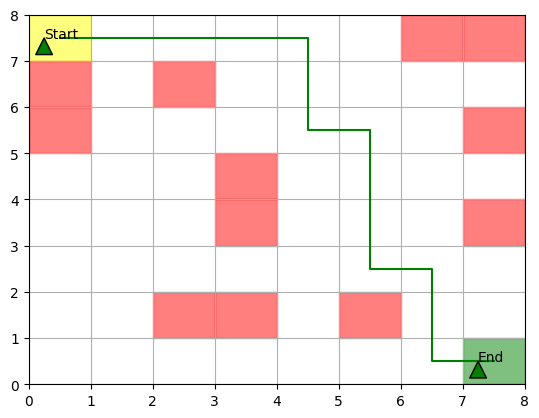

In [67]:
plot_solution(env['world'], q_route)

#### Sarsa <a id = 'sarsacode'></a>
[Sarsa algorithm](#Sarsa)<br>
[Top](#top)<br>

In [68]:
def sarsa_method(env, gw, agent, theta = 1e-9, runs = 1000):
    """
    navigates gridworld using sarsa
    params:
        gw: grid world instance
        agent: type of agent (using e-greedy)
        theta: threshold to stop training ( not being used currently)
        runs: how many episodes to run
    returns:
        V: states and values as dict
        est_lst: list of estimated values after each episode (for calculating rmse later)
        route: optimal policy to solve maze
        printed_final_world: text version of gridworld values, just used for visual inspection
    """

    c = 0
    max_tries = 10000
    d_lst = []
    est_lst = []
    
    # iterate thru runs, run ends when c > max-tries or agent reaches goal
    for i in range(runs):
        agent.state = agent.start
        life = 99
        while True: #delta > theta:
            state = tuple(agent.state)
            if gw.terminal(state):
                agent.V[state] = 0
                break
                
            else:
                # get possible actions
                actions = gw.actions(state)
                # e greedy selection of action
                action_idx = agent.action_selection()
                # n,s,e,w selected
                a = actions[action_idx]
                # adding 1 to make indexing work in dict of q values
                a_key = actions.index(actions[action_idx]) + 1
                # calculate the value of the state
                agent.calc_v(gw, actions)
                # calculate q learning
                agent.step(gw, a, a_key)
                life += agent.R[state]
            c += 1
            if c > max_tries or life <= 0:
                c = 0
#                 print("reached max tries")
                break

        # append estimated values to list for end of episode
        est_lst.append(agent.V.copy())
        
    printed_final_world = print_final_world_txt(agent.V, gw)
    route = make_path(gw, agent, env['states'], agent.V)
            
    return agent.V, agent.Q, est_lst, route, printed_final_world

In [71]:
m,n = 8,8
# world = make_grid_world(m,n, (0,0), (m-1,n-1), -1, -100)
# world = make_demo_maze_world(m,n, (0,0), (m-1,n-1), -1, -100)
world = make_rand_maze_world2(m,n, (0,0), (m-1,n-1), -1, -100, 100)
# world = make_rand_maze_world(m,n, (0,0), (m-1,n-1), -1, -100)
# world = make_pit_world(m,n, (0,0), (m-1,n-1), -1, -100, 100)

e = Environment(*world,[1,2,3,4])
env = e.environment_dict()
s_agent = SarsaAgent(agent = 'e_greedy', 
                 epsilon = 0.1,
                 gamma = 0.9,
                 lr = 0.1,
                 env = env)
cw = GridWorld(m, n, env['world'], env['walls'])
sar_values, sar_q_values, sar_est_lst, sar_route, sar_printed_final_world = sarsa_method(env, cw, s_agent)

In [72]:
def plot_rmse(method1, method2, alphas, g):
    """plots rmse value over episodes
    params: method x is learning rule used and the errors from it
    returns: None, displays plot"""
    
    plt.figure(figsize = (10,10))
    c = ['r','b','g','k']
    for i, p in enumerate(method1):
        plt.plot(p, color = c[i], label = f"sarsa alpha = {alphas[i]}")
    for i, p in enumerate(method2):
        plt.plot(p, f"{c[i]}--", label = f"Q learning alpha = {alphas[i]}")
    plt.title(f"RMS Error of estimated value across episodes (gamma = {g})")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

In [75]:
def main():
    """runs experiment
    using given parameters, runs q learning and sarsa methods of updating gridworld values
    params:
        none, set parameters within main()
    returns:
        q_route: route select by q learning method
        sarsa_route: route select by sarsa method
        p: plot comparing both methods
        q_printed_final_world: printed V table for q method
        sar_printed_final_world: printed V table for sarsa method
    """

    np.random.seed(1)
    
    m, n = 8, 8
    world_dict = {
        'm': m, 
        'n': n, 
        'start': (0,0), 
        'goal': (m-1,n-1), 
        'move_reward': -1, 
        'obstacle_reward': -100, 
        'goal_reward': 100}

    world = make_rand_maze_world2(*[*world_dict.values()])
    # world = make_pit_world(m,n, (0,0), (m-1,n-1), -1, -100, 100)

    # create environment
    e = Environment(*world,[1,2,3,4])
    env = e.environment_dict()

    # create gridworld
    gw = GridWorld(m, n, env['world'], env['walls'])    
    
    # agents
    EPSILON = 0.1
    GAMMA = 0.99
#     LR = 0.1
    THETA = 1e-4

    alphas = [0.1]

    runs = 10000
    
    est_q = []
    q_rmse = []
    est_sarsa = []
    sarsa_rmse = []
    for LR in alphas:
        tmp_q = [] # holds all est for runs
        
        # Q agent
        q_agent = QAgent(agent = 'e_greedy', 
                     epsilon = EPSILON,
                     gamma = GAMMA,
                     lr = LR,
                     env = env)
        
        q_results_v, q_results_q, q_est_lst, q_route, q_printed_final_world = do_q_learning(env, gw, q_agent, THETA, runs)
        
        tmp_q.append(q_est_lst) # all estimates for above results
        est_q.append(tmp_q) # append to larger list in case of multiple alhpas

        tmp_sar = []
        
        # sarsa agent
        sarsa_agent = SarsaAgent(agent = 'e_greedy', 
                     epsilon = EPSILON,
                     gamma = GAMMA,
                     lr = LR,
                     env = env)
        
        sarsa_results_v, sarsa_results_q, sarsa_est_lst, sarsa_route, sarsa_printed_final_world = sarsa_method(env, gw, sarsa_agent, THETA, runs)
        
        tmp_sar.append(sarsa_est_lst) # all estimates for above results
        est_sarsa.append(tmp_sar) # append to larger list in case of multiple alhpas
        
        tmp_q_rmse = calc_rmse(est_q, q_results_v) # get rmse for each run
        q_rmse.append(tmp_q_rmse) # append above for each alpha
        tmp_sarsa_rmse = calc_rmse(est_sarsa, sarsa_results_v) # get rmse for each run
        sarsa_rmse.append(tmp_sarsa_rmse) # append above for each alpha
    p = plot_rmse(q_rmse, sarsa_rmse, alphas, GAMMA)
    
    return q_route, q_results_q, q_results_v, sarsa_route, sarsa_results_q, sarsa_results_v, p, q_printed_final_world, sarsa_printed_final_world, gw

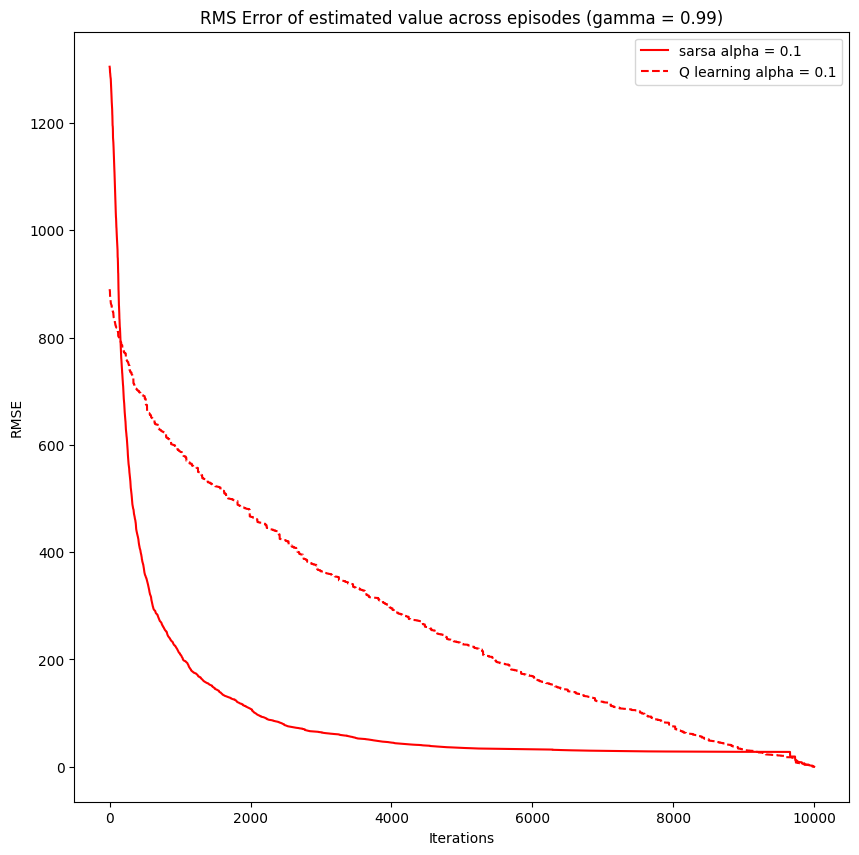

In [76]:
q_route, q_results_q, q_results_v, sarsa_route, sarsa_results_q, sarsa_results_v, p, q_printed_final_world, sarsa_printed_final_world, gw = main()

### Summary
[Top](#top)<br><br>
The plot above shows that in as little as ~175 episodes Q learning converges to near 0 RMSE. The sarsa method takes significantly longer, and appears to converge near ~900 episodes. This is due to the fact that Q learning is an off policy TD control method and is able to learn the optimal path while taking other actions. Sarsa is an on policy TD control method and can only learn from the actions it takes, not other possible best actions. The results of this can be seen in the plot of the RMSE where Q learning converges much quicker than sarsa.

### Optimal policies <a id = 'opt'></a>
[Top](#top)<br><br>
Each path is visualized with the agent moving through the grid world following an optimal policy. There are multiple optimal solutions to this grid world and the agent will take one of them. Below each visualized path is the V table showing the learned value for each state. These V table are sufficient to allow an agent to move through the environment towards the goal without taking a suboptimal path.

Below each V table is a table showing the learned Q value for each action in each state. The states are labeled using (0,0) as the top left corner and (7,7) as the bottom right corner.

### Q route solution <a id = 'optQ'></a>
[Top](#top)<br><br>

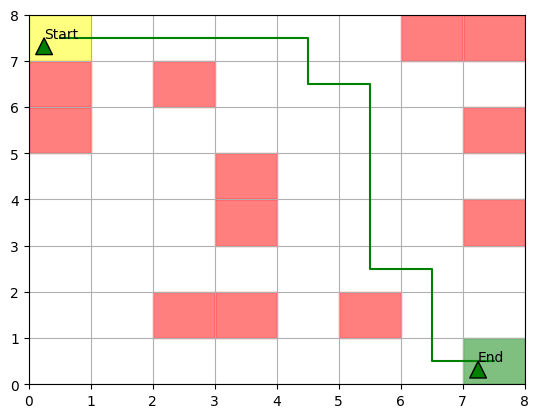

V Table

| -1629.82   | -1559.87   | -1506.01   | -1418.82   | -1365.44   | -1371.72   | -1368.34   | -1252.71   | 
| -1661.68   | -1602.86   | -1496.46   | -1438.82   | -1358.16   | -1334.02   | -1353.76   | -1344.54   | 
| -1616.73   | -1554.23   | -1496.87   | -1436.1    | -1347.24   | -1302.44   | -1318.93   | -1328.43   | 
| -1497.92   | -1459.41   | -1457.18   | -1416.25   | -1343.39   | -1259.12   | -1240.49   | -1275.58   | 
| -1380.81   | -1383.46   | -1411.04   | -1383.65   | -1301.38   | -1197.26   | -1154.45   | -1134.89   | 
| -1315.42   | -1335.51   | -1372.87   | -1359.68   | -1233.07   | -1118.47   | -987.83    | -918.25    | 
| -1280.6    | -1320.43   | -1336.7    | -1300.09   | -1198.57   | -996.99    | -796.22    | -565.21    | 
| -1254.55   | -1278.22   | -1307.34   | -1256.24   | -1108.65   | -911.94    | -563.12    | 0          | 


In [77]:
plot_solution(gw.world, q_route)
print(f"V Table\n\n{q_printed_final_world}")

### Q values
#### Q learning

This table shows the state and the Q value for each possible action within the state.

In [78]:
pd.DataFrame({
    'State':[x for x in sarsa_results_q.keys()],
    'N':[np.round(v[1],3) for k,v in q_results_q.items()],
    'S':[np.round(v[2],3) for k,v in q_results_q.items()],
    'E':[np.round(v[3],3) for k,v in q_results_q.items()],
    'W':[np.round(v[4],3) for k,v in q_results_q.items()]
})

,State,N,S,E,W
0,"(0, 0)",-13.994,-111.135,-13.125,-13.994
1,"(0, 1)",-13.125,-12.248,-12.248,-13.994
2,"(0, 2)",-12.248,-109.369,-11.362,-13.125
3,"(0, 3)",-11.362,-10.466,-10.466,-12.248
4,"(0, 4)",-10.457,-9.562,-9.562,-11.357
5,"(0, 5)",-9.514,-8.648,-84.695,-10.440
6,"(0, 6)",-108.763,-102.067,-103.181,-102.019
7,"(0, 7)",-29.970,-27.790,-29.079,-41.005
8,"(1, 0)",-112.271,-156.888,-111.248,-174.478
9,"(1, 1)",-13.125,-11.362,-109.366,-111.135


### Sarsa route solution <a id = 'optSar'></a>
[Top](#top)<br><br>

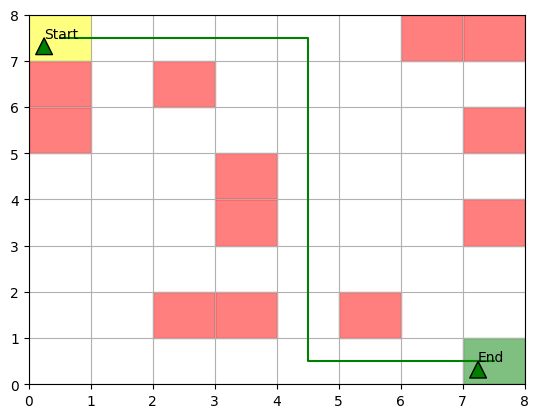

V Table

| -1311.47   | -1243.09   | -1193.91   | -1116.59   | -1082.95   | -1124.42   | -1184.82   | -1171.27   | 
| -1328.89   | -1270.1    | -1166.37   | -1115.11   | -1048.46   | -1047.68   | -1103.25   | -1138.62   | 
| -1254.86   | -1189.67   | -1129.49   | -1070.33   | -987.79    | -953.04    | -985.58    | -1009.77   | 
| -1093.11   | -1048.59   | -1034.23   | -991.95    | -915.77    | -833.92    | -819.57    | -845.78    | 
| -920.22    | -916.31    | -925.1     | -885.53    | -788.35    | -690.44    | -654.58    | -629.02    | 
| -797.16    | -806.41    | -814.6     | -773.02    | -618.92    | -523.57    | -431.47    | -389.74    | 
| -704.81    | -727.66    | -709.17    | -612.84    | -435.02    | -335.74    | -239.98    | -153.65    | 
| -653.64    | -644.55    | -606.21    | -504.6     | -241.02    | -153.92    | -66.82     | 0          | 


In [79]:
plot_solution(gw.world, sarsa_route)
print(f"V Table\n\n{sarsa_printed_final_world}")

### Q values
#### Sarsa

This table shows the state and the Q value for each possible action within the state.

In [80]:
pd.DataFrame({
    'State':[x for x in sarsa_results_q.keys()],
    'N':[np.round(v[1],3) for k,v in sarsa_results_q.items()],
    'S':[np.round(v[2],3) for k,v in sarsa_results_q.items()],
    'E':[np.round(v[3],3) for k,v in sarsa_results_q.items()],
    'W':[np.round(v[4],3) for k,v in sarsa_results_q.items()]
})

,State,N,S,E,W
0,"(0, 0)",-99.828,-99.828,-99.828,-99.828
1,"(0, 1)",-93.467,-93.467,-93.467,-93.467
2,"(0, 2)",-66.025,-66.059,-66.025,-65.991
3,"(0, 3)",-39.906,-39.906,-39.966,-39.966
4,"(0, 4)",-23.059,-23.059,-23.059,-22.982
5,"(0, 5)",-11.047,-11.136,-11.136,-11.136
6,"(0, 6)",-373.054,-373.054,-373.054,-363.417
7,"(0, 7)",-19.990,-19.990,-29.970,-29.970
8,"(1, 0)",-8308.363,-8308.363,-8308.363,-8308.363
9,"(1, 1)",-52.306,-52.306,-52.306,-52.306
